In [30]:
%matplotlib inline

import importlib
import sys
sys.path.insert(0, '../util')
import utils; importlib.reload(utils)
from utils import *
from vgg16_avg import VGG16_Avg

In [31]:
# Tell Tensorflow to use no more GPU RAM than necessary
utils.limit_mem()

In [32]:
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)
        
    def get_output_shape_for(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

In [33]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x) if act else x

def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return merge([x, ip], mode='sum')

def res_crop_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1), 'valid')
    x = conv_block(x,  nf, 3, (1,1), 'valid', False)
    ip = Lambda(lambda x: x[:, 2:-2, 2:-2])(ip)
    return merge([x, ip], mode='sum')

def deconv_block(x, filters, size, shape, stride=(2,2)):
    x = Deconvolution2D(filters, size, size, subsample=stride, 
        border_mode='same', output_shape=(None,)+shape)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)

def up_block(x, filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = Convolution2D(filters, size, size, border_mode='same')(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)


In [34]:
dpath = '/mnt/data/manish/data/'

In [35]:
arr_lr = bcolz.open(dpath+'trn_resized_72.bc')[:]
arr_hr = bcolz.open(dpath+'trn_resized_288.bc')[:]

# use small data for local testing
# arr_lr = bcolz.open(dpath+'trn_resized_72.bc')[:2000]
# arr_hr = bcolz.open(dpath+'trn_resized_288.bc')[:2000]

In [36]:
# parms = {'verbose': 1, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}
parms = {'verbose': 1, 'callbacks': []}

In [37]:
shp = arr_hr.shape[1:]

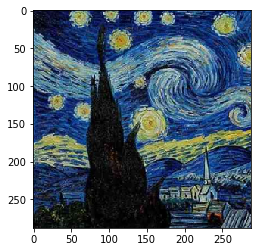

In [38]:
style = Image.open('./data/starry_night.jpg')
style = style.resize(np.divide(style.size,3.5).astype('int32'))
style = np.array(style)[:shp[0], :shp[1], :shp[2]]
plt.imshow(style);

In [39]:
inp=Input(shp)
x=ReflectionPadding2D((40, 40))(inp)
x=conv_block(x, 64, 9, (1,1))
x=conv_block(x, 64, 3)
x=conv_block(x, 64, 3)
for i in range(5): x=res_crop_block(x)
x=up_block(x, 64, 3)
x=up_block(x, 64, 3)
x=Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
outp=Lambda(lambda x: (x+1)*127.5)(x)

In [40]:
preproc = lambda x: (x-imagenet_mean)[:,:,:,::-1]
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + imagenet_mean, 0, 255)

In [41]:
vgg_inp=Input(shp)
vgg= VGG16(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))
for l in vgg.layers: l.trainable=False

In [42]:
def get_outp(m, ln): return m.get_layer('block{}_conv2'.format(ln)).output
vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [2,3,4,5]])

In [43]:
# Here we alter the super resolution approach by adding style outputs
style_targs = [K.variable(o) for o in
               vgg_content.predict(np.expand_dims(style,0))]

In [44]:
[K.eval(K.shape(o)) for o in style_targs]

[array([  1, 144, 144, 128], dtype=int32),
 array([  1,  72,  72, 256], dtype=int32),
 array([  1,  36,  36, 512], dtype=int32),
 array([  1,  18,  18, 512], dtype=int32)]

In [45]:
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

In [46]:
# Our loss now includes the mse for the content loss and the gram matrix for the style
def gram_matrix_b(x):
    x = K.permute_dimensions(x, (0, 3, 1, 2))
    s = K.shape(x)
    feat = K.reshape(x, (s[0], s[1], s[2]*s[3]))
    return K.batch_dot(feat, K.permute_dimensions(feat, (0, 2, 1))
                      ) / K.prod(K.cast(s[1:], K.floatx()))



In [47]:
def mean_sqr_b(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

In [48]:
w=[0.1, 0.2, 0.6, 0.1]
def tot_loss(x):
    loss = 0; n = len(style_targs)
    for i in range(n):
        loss += mean_sqr_b(gram_matrix_b(x[i+n]) - gram_matrix_b(style_targs[i])) / 2.
        loss += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return loss

In [49]:
loss = Lambda(tot_loss)(vgg1+vgg2)
m_style = Model([inp, vgg_inp], loss)
targ = np.zeros((arr_hr.shape[0], 1))

In [ ]:
m_style.compile('adam', 'mae')
m_style.fit([arr_hr, arr_hr], targ, 16, 10, **parms)

Epoch 1/10
15568/19439 [=======================>......] - ETA: 331s - loss: 398.2801

In [ ]:
K.set_value(m_style.optimizer.lr, 1e-4)
m_style.fit([arr_hr, arr_hr], targ, 16, 2, **parms)

In [82]:
top_model = Model(inp, outp)

In [93]:
p = top_model.predict(arr_hr[:50])

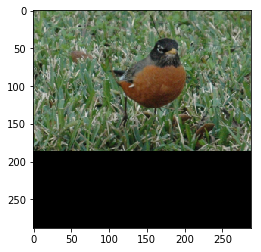

In [112]:
plt.imshow(arr_hr[34].astype('uint8'));

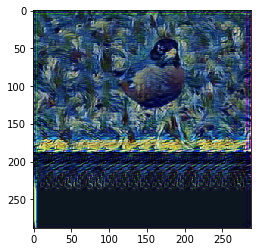

In [113]:
plt.imshow(np.round(p[34]).astype('uint8'));

In [87]:
top_model.save_weights(dpath+'style_final.h5')